## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos        VIX  EMV-ID     EPU
0    2010-01-01    0.000000  22.543626    2.01  174.55
1    2010-01-02    4.256365  22.171185    0.00  119.52
2    2010-01-03    0.794545  21.143152    1.15  216.95
3    2010-01-04    0.787899  20.040000    1.22  150.35
4    2010-01-05    0.601027  19.350000    0.95  151.16
...         ...         ...        ...     ...     ...
3648 2019-12-27    4.003614  13.430000    0.00  127.92
3649 2019-12-28    2.090121  14.351756    0.00  123.10
3650 2019-12-29    0.539108  14.946538    4.26  245.14
3651 2019-12-30    1.815513  14.820000    0.97  101.31
3652 2019-12-31    1.871355  13.780000    1.54  105.75

[3653 rows x 5 columns]

---

## Desarrollo del modelo RF

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(1093, 1)
(1093, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.20017021894122344
MAE is : 0.3229164484155087
RMSE is : 0.44740386558591944
MAPE is : 16.203045567682857
Evaluation metric results:
MSE is : 1.1406831339712566
MAE is : 0.8357918626743417
RMSE is : 1.0680276840846668
MAPE is : 47.28849665964164
(1093, 1)
(1093, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19250683689943027
MAE is : 0.3198098120537221
RMSE is : 0.43875601067042974
MAPE is : 16.015409463236292
Evaluation metric results:
MSE is : 1.0961034632256248
MAE is : 0.8239967349262072
RMSE is : 1.046949599181176
MAPE is : 46.780348127130246
(1093, 1)
(1093, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19068940231154138
MAE is : 0.3184364910129872
RMSE is : 0.43667997699864985
MAPE is : 15.951449710593677
Evaluation metric results:
MSE is : 1.101689172210709
MAE is : 0.8243736517836451
RMSE is : 1.0496138205124343
MAPE is : 46.940432028557964
(1093, 1)
(1093, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18499987170192383
MAE is : 0.3164482998607518
RMSE is : 0.4301161142086214
MAPE is : 15.916490883802116
Evaluation metric results:
MSE is : 1.0958144401700884
MAE is : 0.820833971419927
RMSE is : 1.0468115590544882
MAPE is : 46.66358312309484
(1093, 1)
(1093, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18541373144017853
MAE is : 0.31662436316827636
RMSE is : 0.43059694778316593
MAPE is : 15.858050286248327
Evaluation metric results:
MSE is : 1.0989981983412505
MAE is : 0.8228941344585701
RMSE is : 1.048331149180091
MAPE is : 46.821240810100484
(1091, 1)
(1091, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.21277566111235663
MAE is : 0.3283719592595388
RMSE is : 0.4612761224173181
MAPE is : 16.425673650799418
Evaluation metric results:
MSE is : 1.364400095609712
MAE is : 0.9244707365370929
RMSE is : 1.1680753809620816
MAPE is : 54.075467280137005
(1091, 1)
(1091, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19476439816915006
MAE is : 0.31936723092384867
RMSE is : 0.44132119614760185
MAPE is : 15.889199144932434
Evaluation metric results:
MSE is : 1.3380233820894456
MAE is : 0.916523476847739
RMSE is : 1.1567296062993484
MAPE is : 53.40278513191132
(1091, 1)
(1091, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.1892727855206141
MAE is : 0.3202009512688981
RMSE is : 0.4350549224185541
MAPE is : 16.09511079581589
Evaluation metric results:
MSE is : 1.3211373683918903
MAE is : 0.9122791912759004
RMSE is : 1.1494073987894329
MAPE is : 53.39278230059392
(1091, 1)
(1091, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.18832897390043063
MAE is : 0.3184235864772699
RMSE is : 0.43396886282362546
MAPE is : 15.907990243578718
Evaluation metric results:
MSE is : 1.3356004079535209
MAE is : 0.9144126940305785
RMSE is : 1.1556817935545756
MAPE is : 53.46034290755565
(1091, 1)
(1091, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.18648354684970275
MAE is : 0.3180310696017844
RMSE is : 0.4318374078860037
MAPE is : 15.999752428528064
Evaluation metric results:
MSE is : 1.3697975506449185
MAE is : 0.9253836015372245
RMSE is : 1.1703835057983851
MAPE is : 54.1944417587102
(1089, 1)
(1089, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.2007912215974145


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


MAE is : 0.32534718155909853
RMSE is : 0.4480973349590628
MAPE is : 16.308373872698105
Evaluation metric results:
MSE is : 1.5809007455659987
MAE is : 0.9747992513918411
RMSE is : 1.2573387552946893
MAPE is : 56.494187869465826
(1089, 1)
(1089, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19724513098306962
MAE is : 0.3221362603875487
RMSE is : 0.4441228782477543
MAPE is : 16.17297864185026
Evaluation metric results:
MSE is : 1.490187673772301
MAE is : 0.9521122436628197
RMSE is : 1.2207324333252971
MAPE is : 55.460808247683055
(1089, 1)
(1089, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.18941441572097112
MAE is : 0.3189947406821376
RMSE is : 0.4352176647620948
MAPE is : 16.05934570992037
Evaluation metric results:
MSE is : 1.4945370871808898
MAE is : 0.9570952125054694
RMSE is : 1.222512612278863
MAPE is : 55.74650856949667
(1089, 1)
(1089, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19040023750858567
MAE is : 0.3185907559272606
RMSE is : 0.4363487567400481
MAPE is : 15.977600927599568
Evaluation metric results:
MSE is : 1.5956374200363248
MAE is : 0.9838102448667334
RMSE is : 1.2631854258327733
MAPE is : 57.372258005634755
(1089, 1)
(1089, 31)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.18746996924177173
MAE is : 0.3186072431285999
RMSE is : 0.43297802397093055
MAPE is : 16.018933890758856
Evaluation metric results:
MSE is : 1.521505705620553
MAE is : 0.9636511727674185
RMSE is : 1.233493293707166
MAPE is : 56.215964370794566
(1088, 1)
(1088, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19952707338271364
MAE is : 0.325685240648992
RMSE is : 0.44668453452376616
MAPE is : 16.36817473074972
Evaluation metric results:
MSE is : 1.7439557321620978
MAE is : 1.0095208966300013
RMSE is : 1.3205891610043214
MAPE is : 58.65867876778294
(1088, 1)
(1088, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19294101457324844
MAE is : 0.32173299474498324
RMSE is : 0.43925051459645265
MAPE is : 16.279029760733405
Evaluation metric results:
MSE is : 1.6017288235921452
MAE is : 0.9760722688102166
RMSE is : 1.2655942570951186
MAPE is : 56.87517814188085
(1088, 1)
(1088, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19612476858023242
MAE is : 0.3219198026329721
RMSE is : 0.4428597617533483
MAPE is : 16.186850115571207
Evaluation metric results:
MSE is : 1.6706898860515789
MAE is : 0.9909201076724765
RMSE is : 1.2925516956979242
MAPE is : 57.69686661648091
(1088, 1)
(1088, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.1900423645656383
MAE is : 0.3183634559991348
RMSE is : 0.43593848713509836
MAPE is : 16.031777712559215
Evaluation metric results:
MSE is : 1.5862360226723797
MAE is : 0.971825836734376
RMSE is : 1.259458622850461
MAPE is : 56.44170341857831
(1088, 1)
(1088, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.18916027780213052
MAE is : 0.31916743655780816
RMSE is : 0.43492560030668526
MAPE is : 16.061002785813727
Evaluation metric results:
MSE is : 1.5697581465852124
MAE is : 0.96861558847102
RMSE is : 1.2528998948779637
MAPE is : 56.35080907591083
(1086, 1)
(1086, 43)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.2043144247577357
MAE is : 0.3263029559444406
RMSE is : 0.45201153166455355
MAPE is : 16.452031283017792
Evaluation metric results:
MSE is : 1.766336300134482
MAE is : 1.0131673214449468
RMSE is : 1.3290358535925515
MAPE is : 58.921960777929904
(1086, 1)
(1086, 43)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19422506464427133
MAE is : 0.32166697631449565
RMSE is : 0.44070972832951094
MAPE is : 16.168786454652437
Evaluation metric results:
MSE is : 1.624675339099989
MAE is : 0.9857199036495349
RMSE is : 1.2746275295551988
MAPE is : 57.433350098949006
(1086, 1)
(1086, 43)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.18896889410077689
MAE is : 0.3198840197151739
RMSE is : 0.4347055257306685
MAPE is : 16.106612769443263
Evaluation metric results:
MSE is : 1.648893520340873
MAE is : 0.9901843365020538
RMSE is : 1.284092489013495
MAPE is : 57.55627373538702
(1086, 1)
(1086, 43)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.18742339772142838
MAE is : 0.3193360268417052
RMSE is : 0.43292424016382863
MAPE is : 16.082200320598456
Evaluation metric results:
MSE is : 1.4961068999791824
MAE is : 0.9513124072512396
RMSE is : 1.223154487372377
MAPE is : 55.32951755015768
(1086, 1)
(1086, 43)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.1889066820651429
MAE is : 0.3190478157271725
RMSE is : 0.43463396331297316
MAPE is : 16.04335263226946
Evaluation metric results:
MSE is : 1.6288723764794608
MAE is : 0.9813909361297575
RMSE is : 1.2762728456248926
MAPE is : 57.06610874795517
(1081, 1)
(1081, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.20113798531455562
MAE is : 0.32445275981430877
RMSE is : 0.44848409705869796
MAPE is : 16.200422473693123
Evaluation metric results:
MSE is : 1.7162339298979017
MAE is : 1.0052749788592994
RMSE is : 1.3100511172843226
MAPE is : 58.47487653452386
(1081, 1)
(1081, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19254001316965058
MAE is : 0.31883664933782185
RMSE is : 0.4387938162390744
MAPE is : 15.918638277405064
Evaluation metric results:
MSE is : 1.5854138698720062
MAE is : 0.9808725494884406
RMSE is : 1.2591321891969907
MAPE is : 56.94884974910168
(1081, 1)
(1081, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18986890322768898
MAE is : 0.3172877578253358
RMSE is : 0.43573949009435553
MAPE is : 15.938140533479134
Evaluation metric results:
MSE is : 1.5871758482398048
MAE is : 0.9757262353189741
RMSE is : 1.2598316745660132
MAPE is : 56.814649546365736
(1081, 1)
(1081, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.1883819858206988
MAE is : 0.31749519779101637
RMSE is : 0.4340299365489652
MAPE is : 15.94859311672289
Evaluation metric results:
MSE is : 1.649638721342784
MAE is : 0.9939960128692578
RMSE is : 1.2843826226412378
MAPE is : 57.97501220530328
(1081, 1)
(1081, 63)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.1891467954762463
MAE is : 0.3187768687218456
RMSE is : 0.43491010045323886
MAPE is : 16.031544256973643
Evaluation metric results:
MSE is : 1.590399641048896
MAE is : 0.9754859238806441
RMSE is : 1.261110479319277
MAPE is : 56.81660126181942


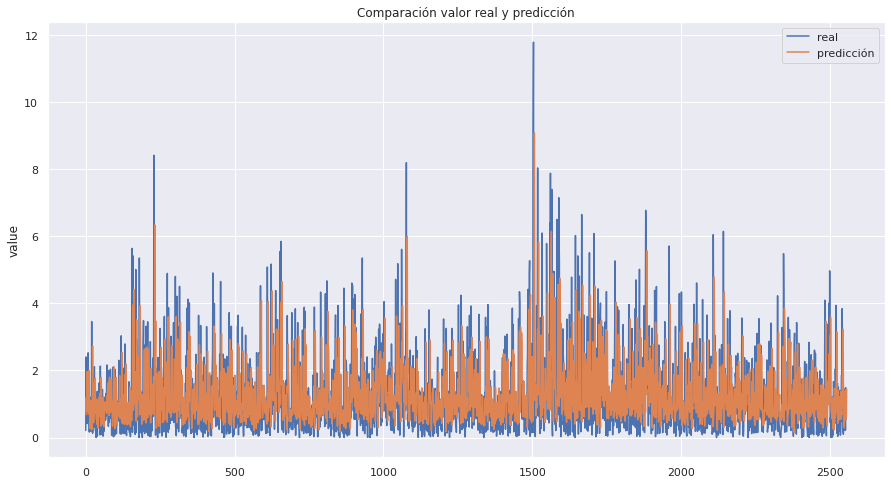

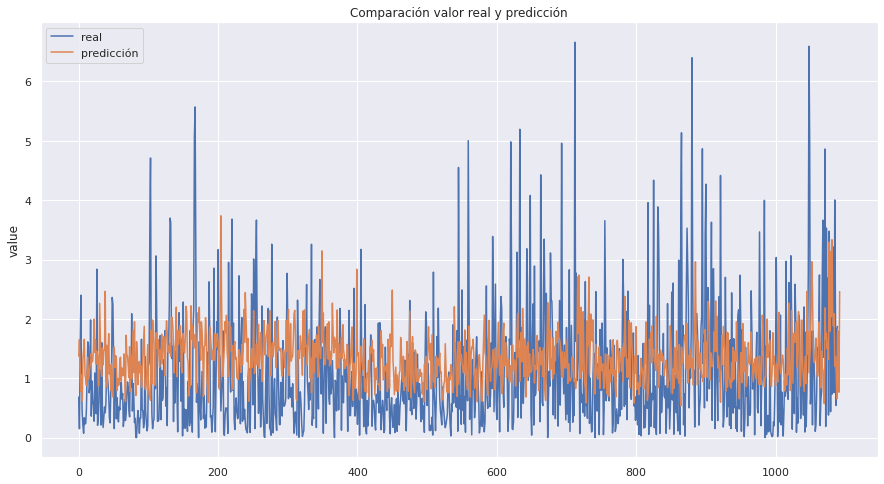

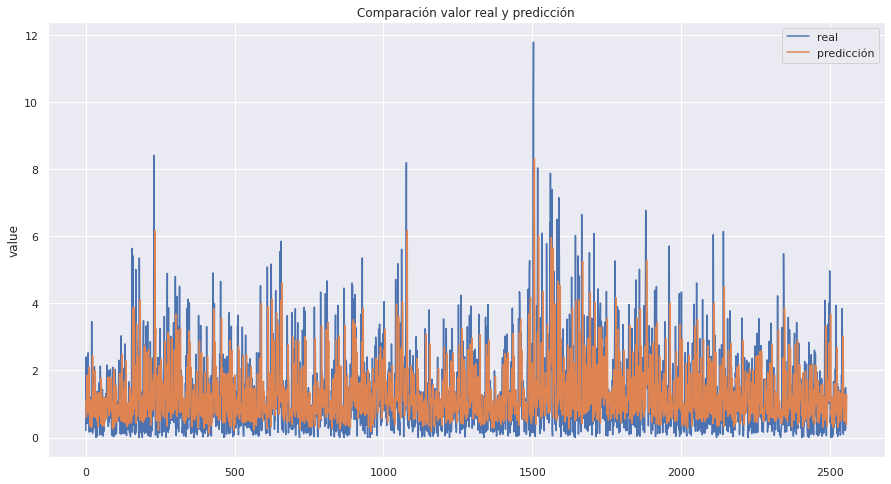

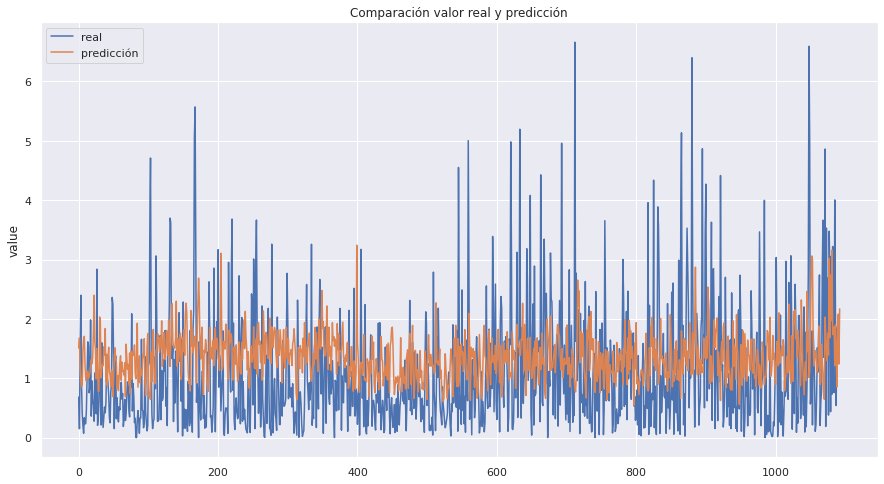

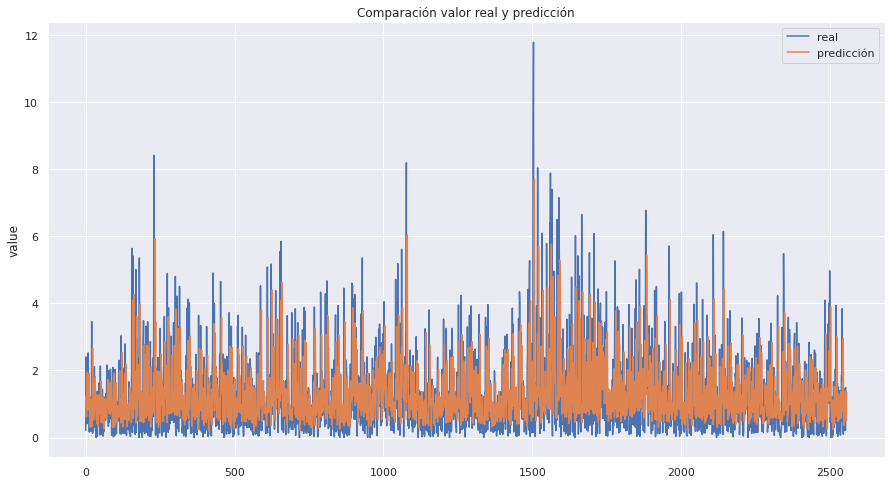

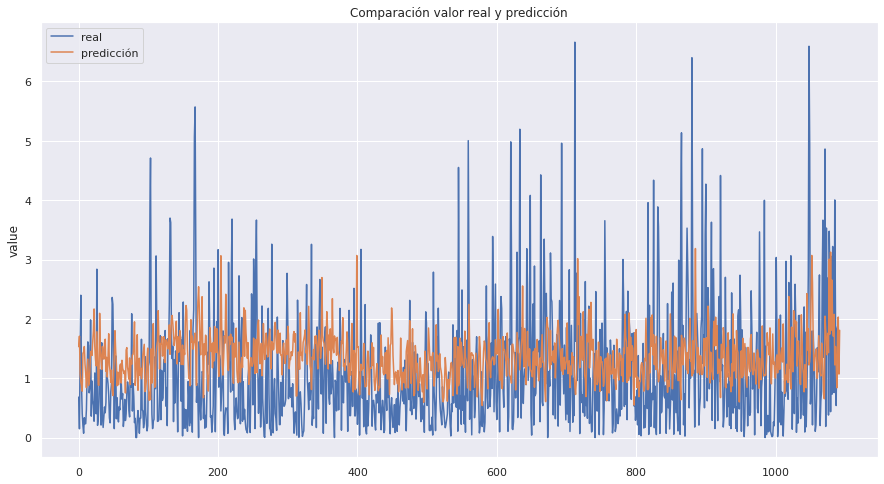

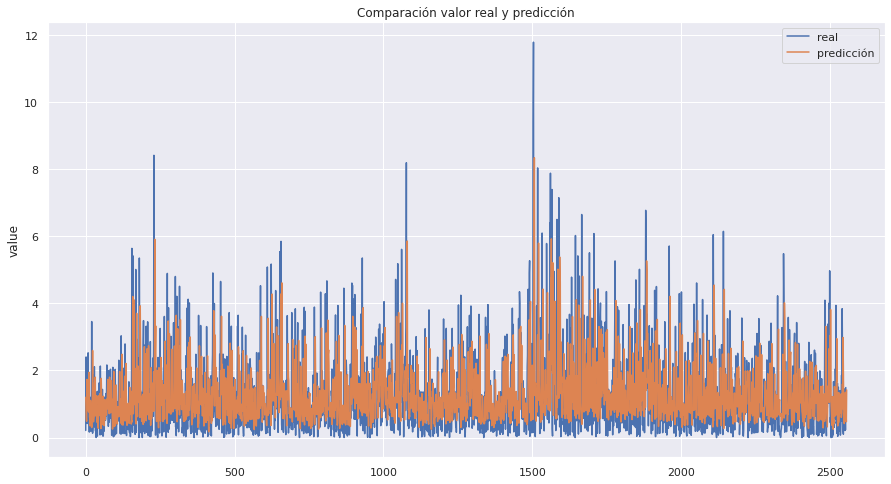

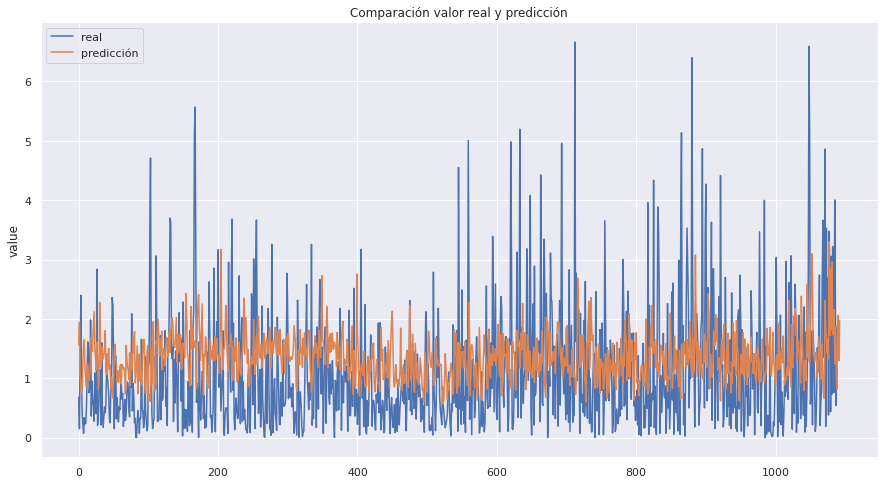

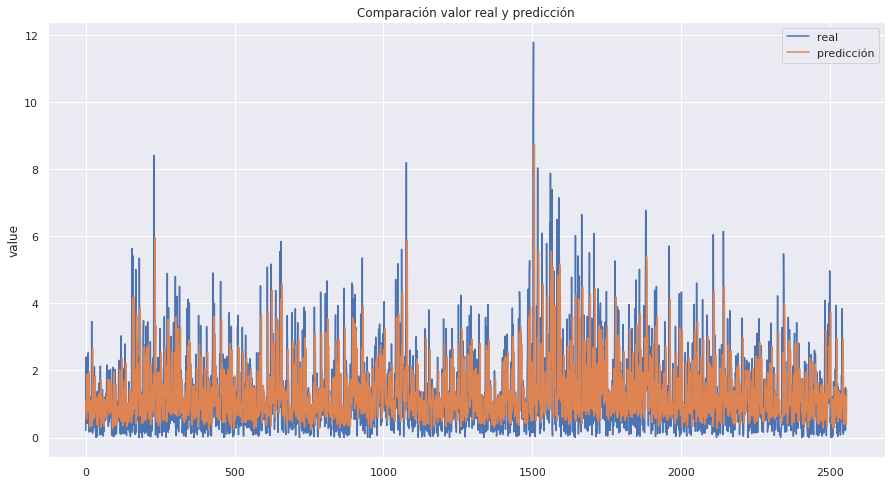

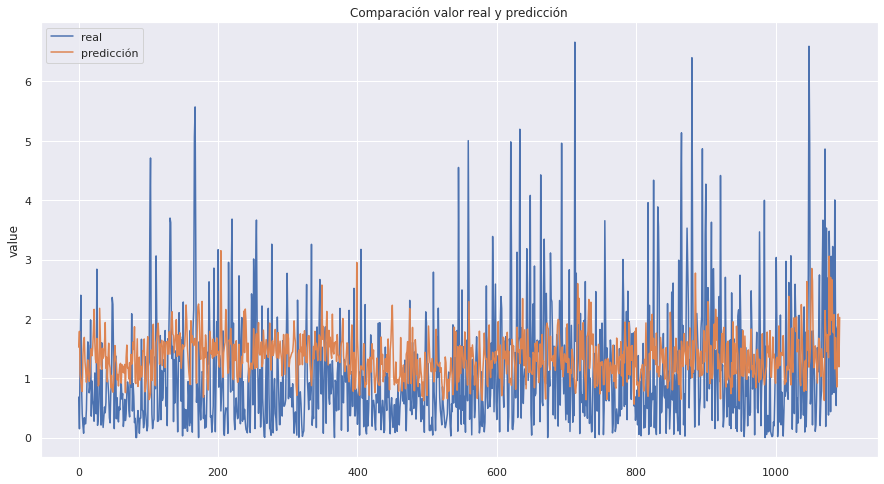

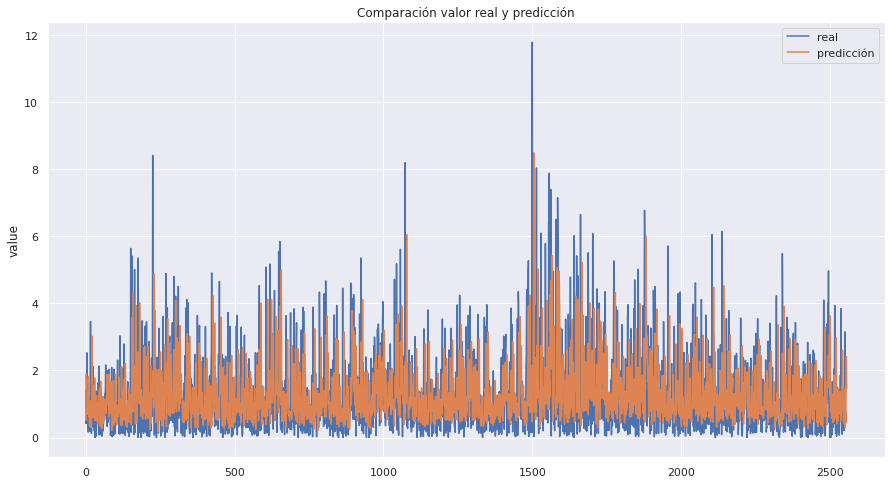

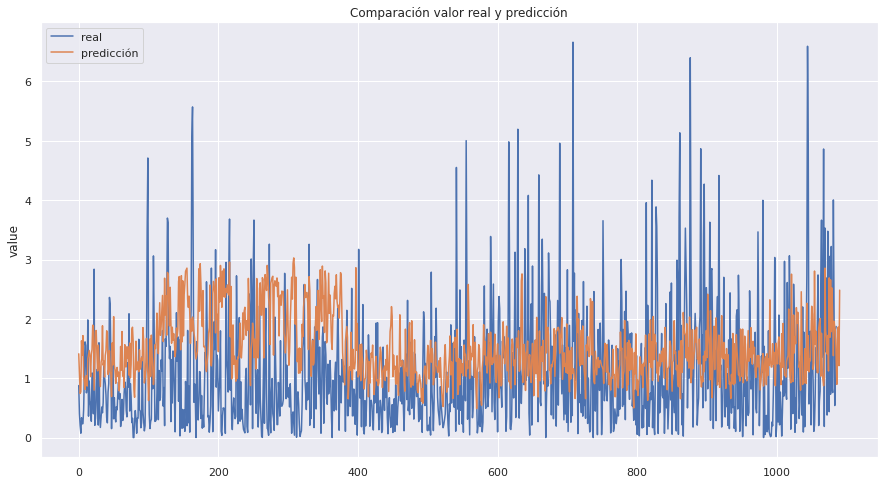

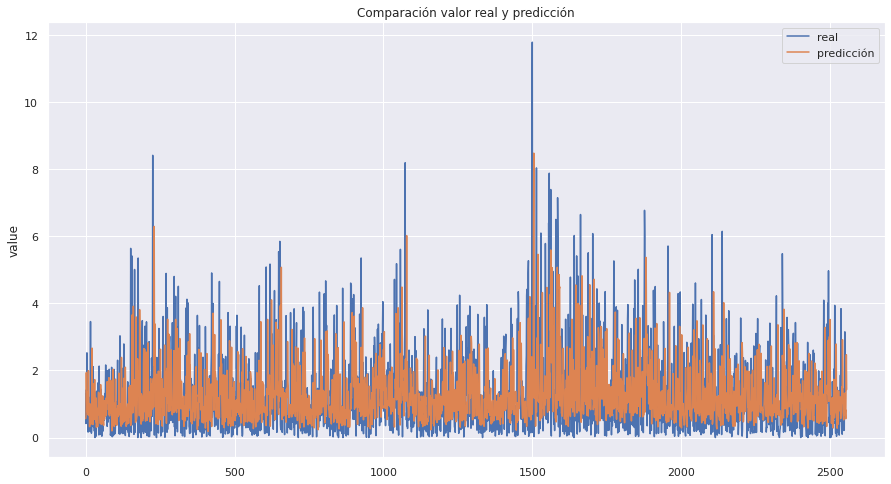

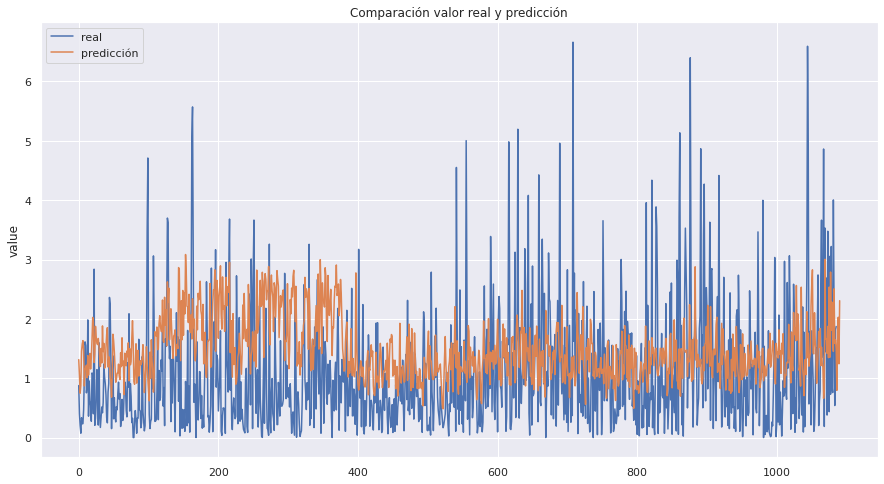

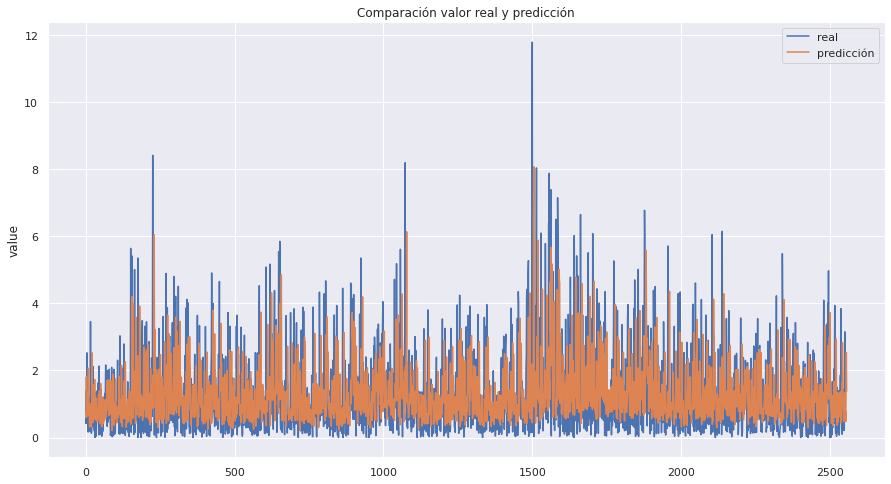

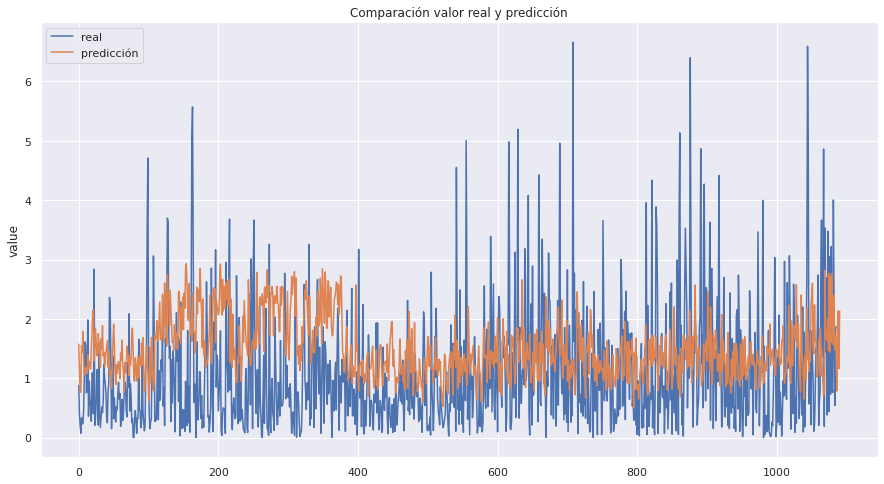

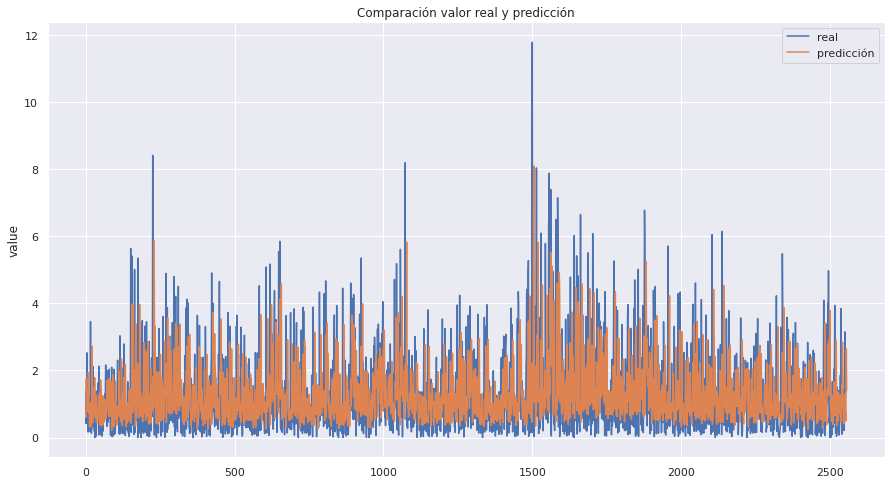

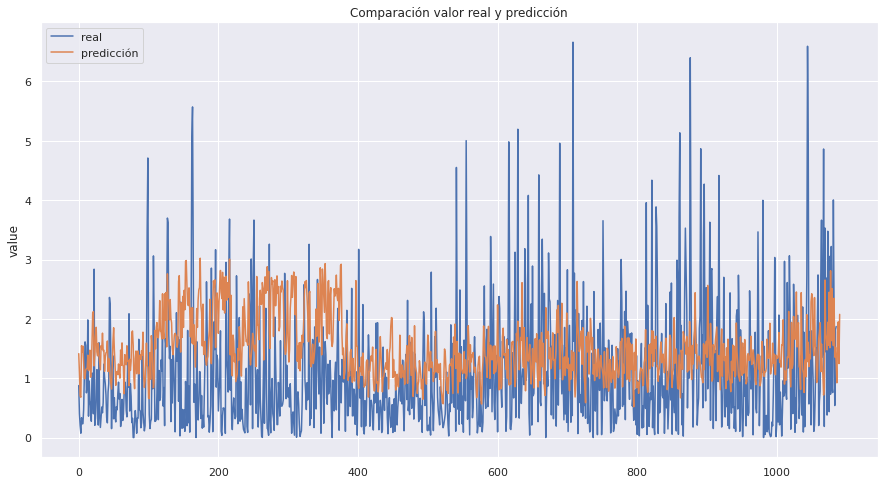

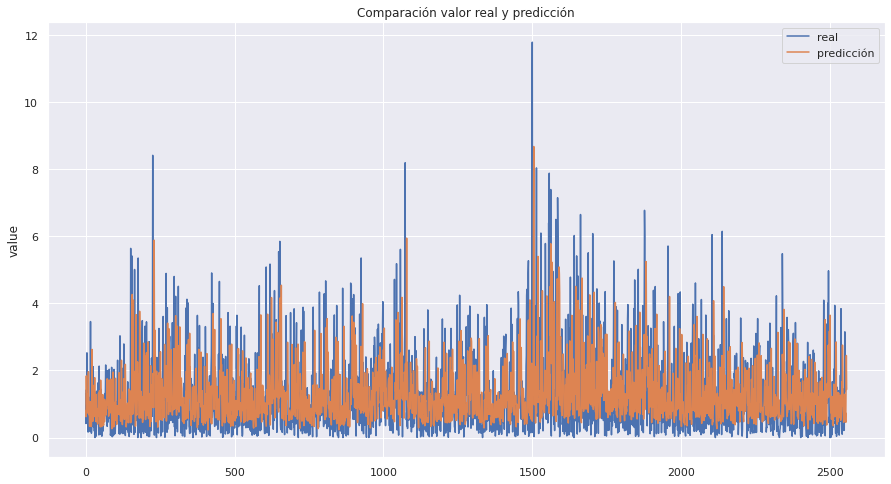

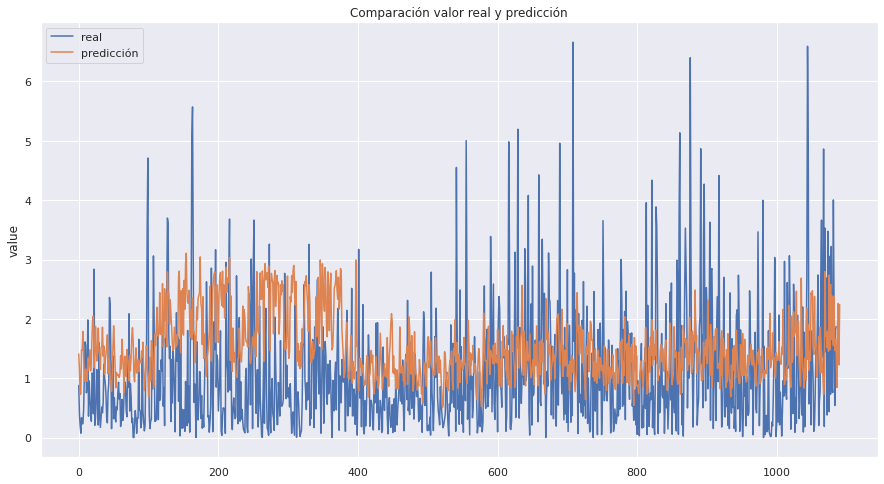

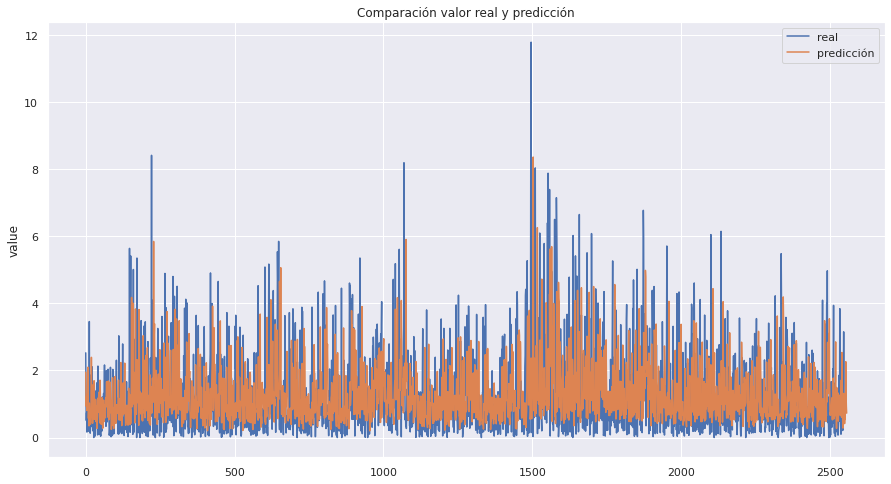

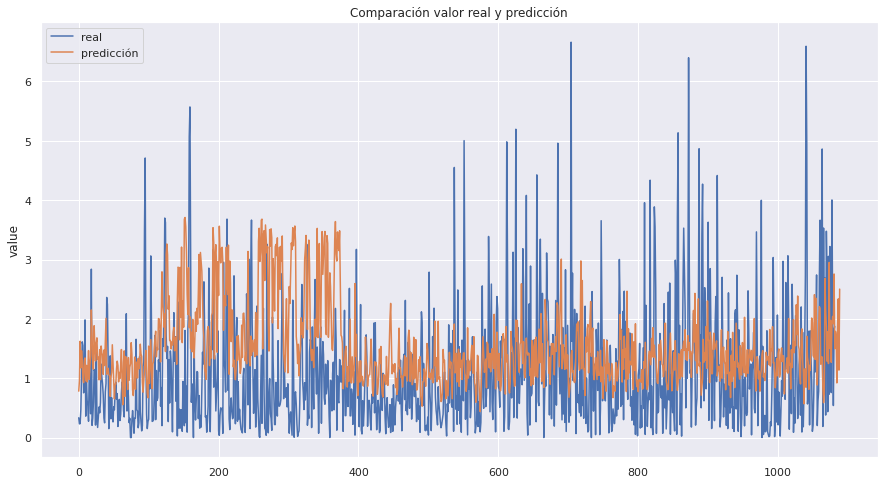

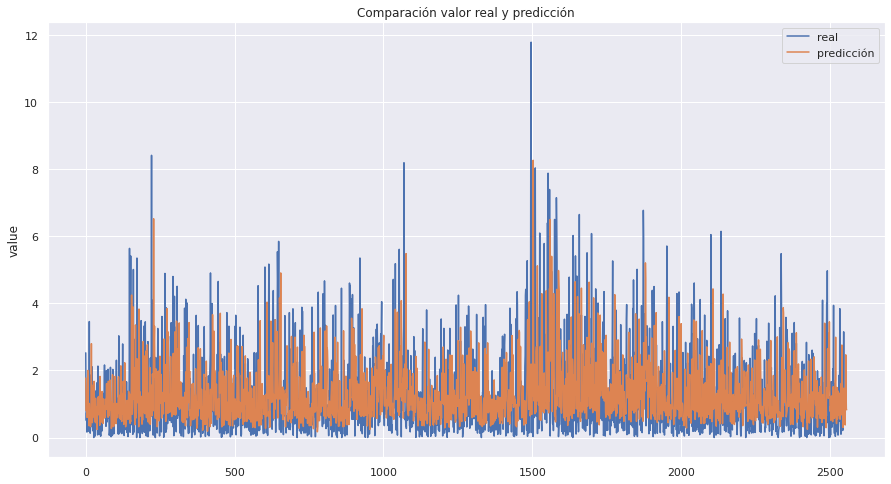

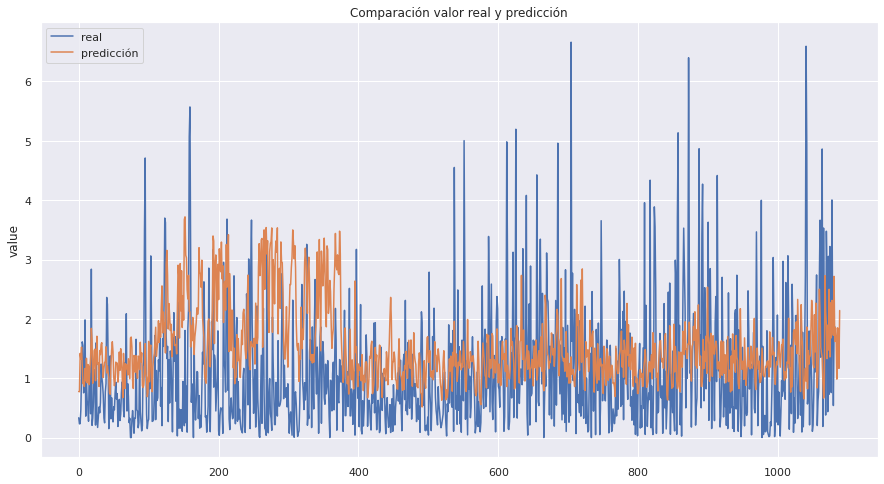

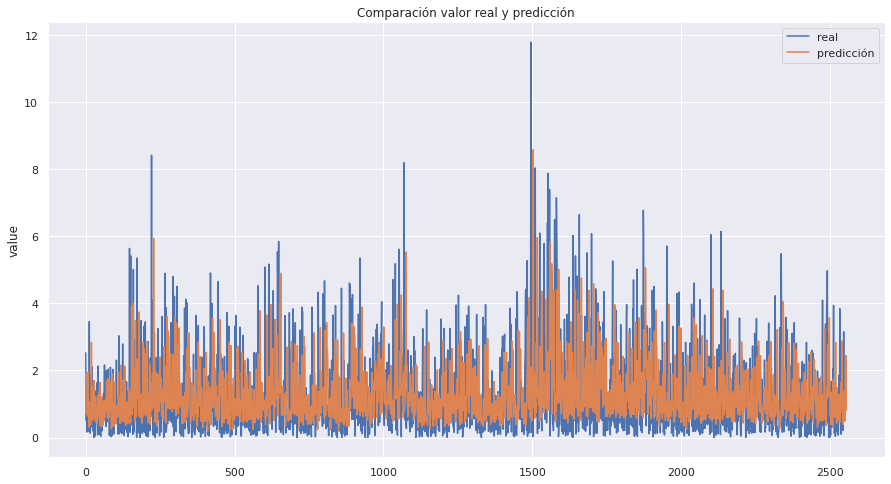

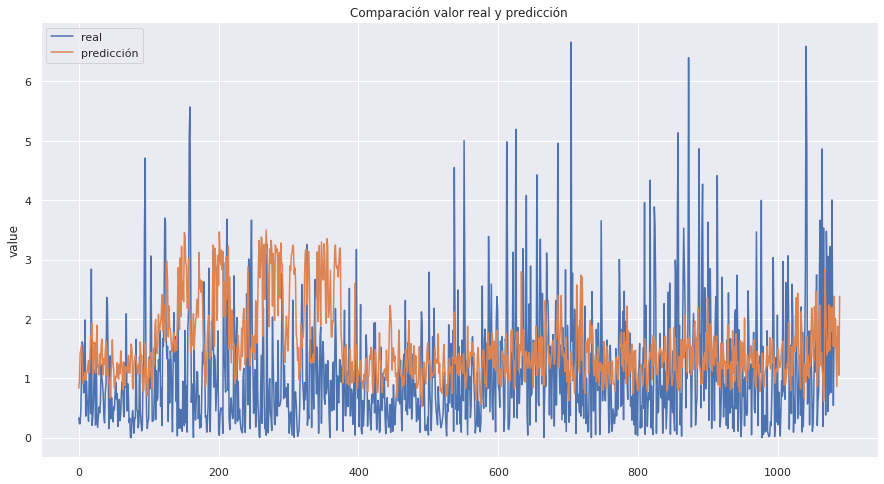

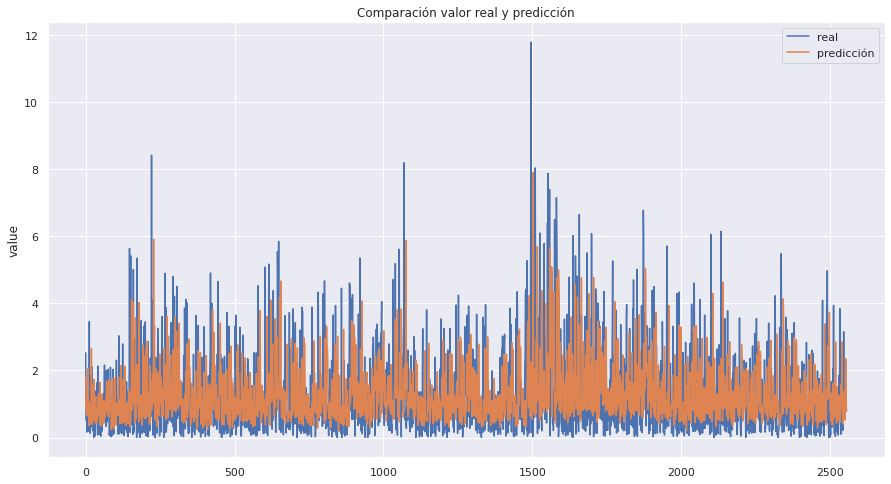

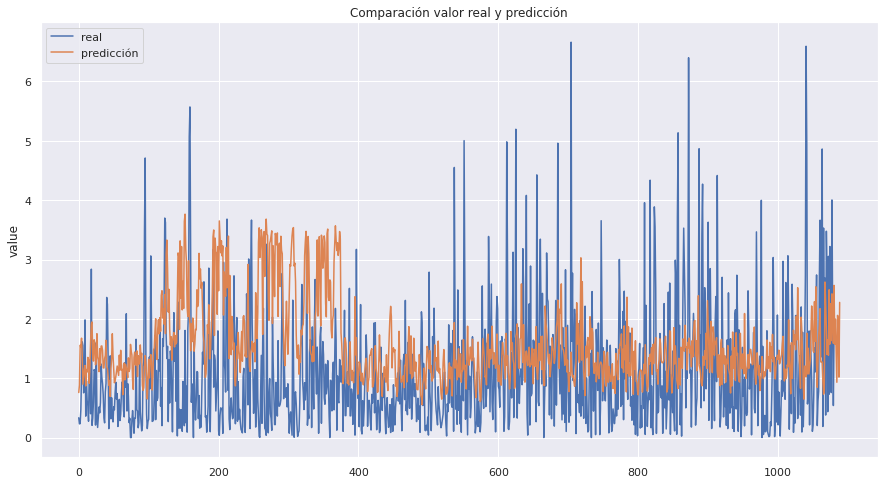

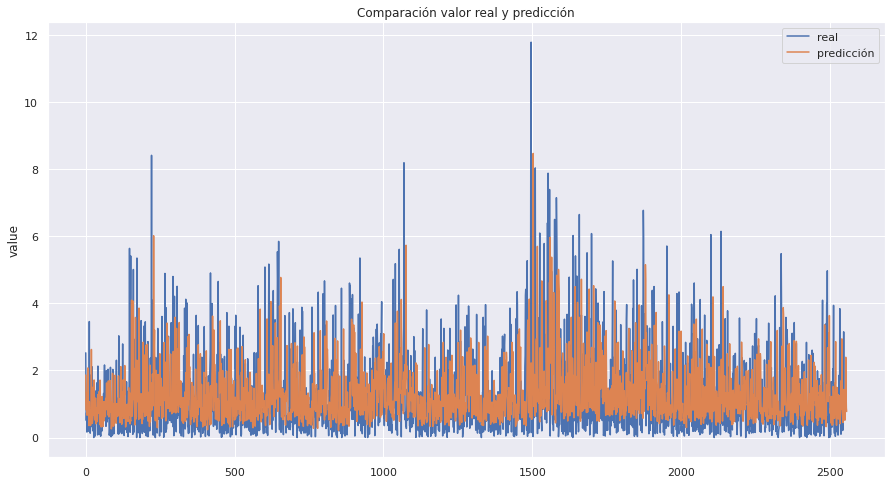

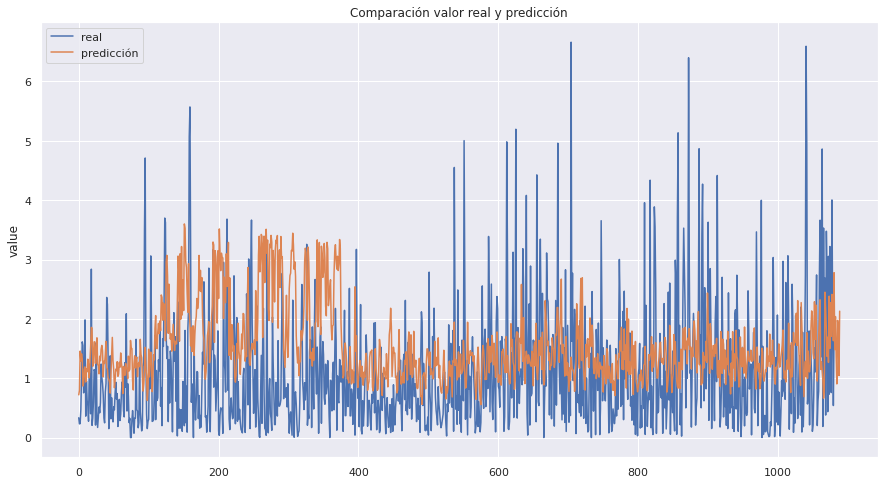

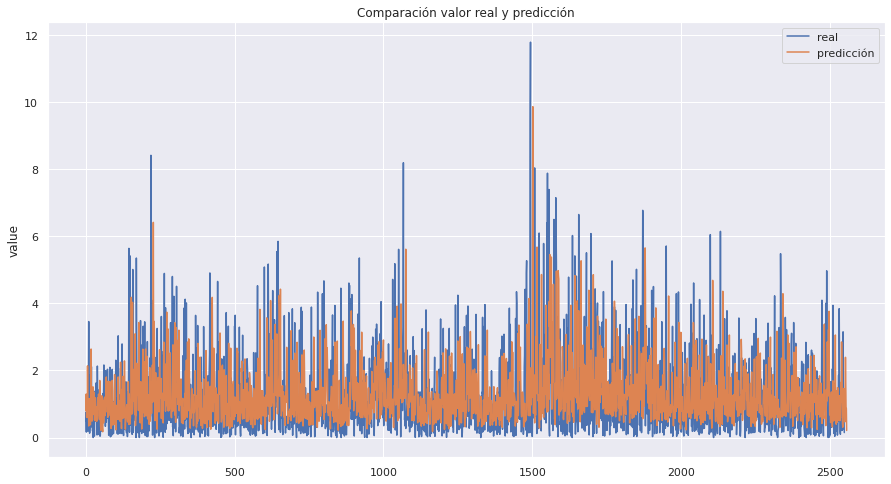

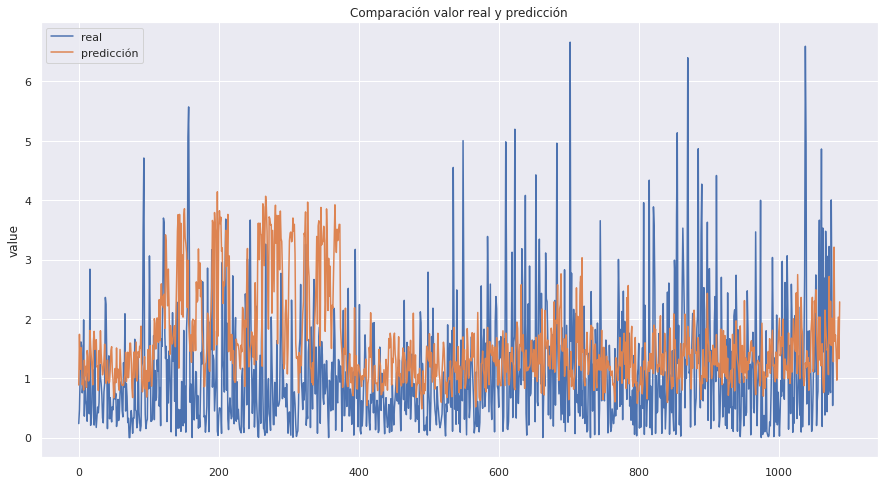

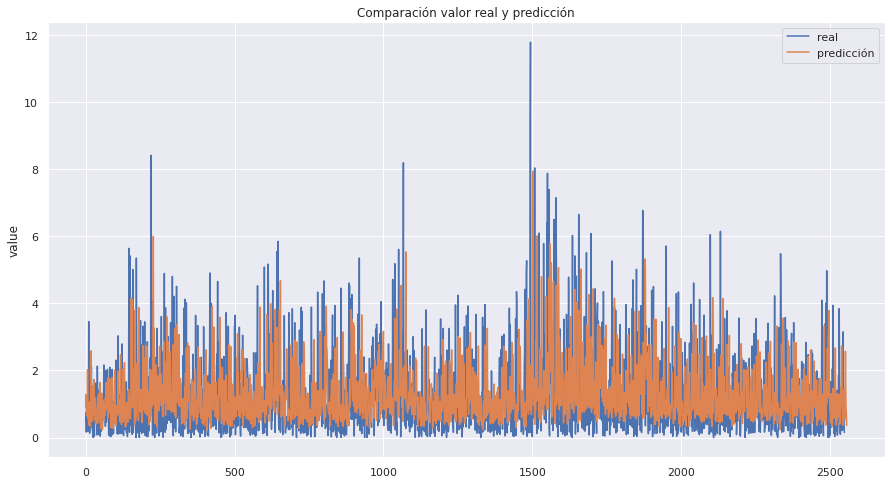

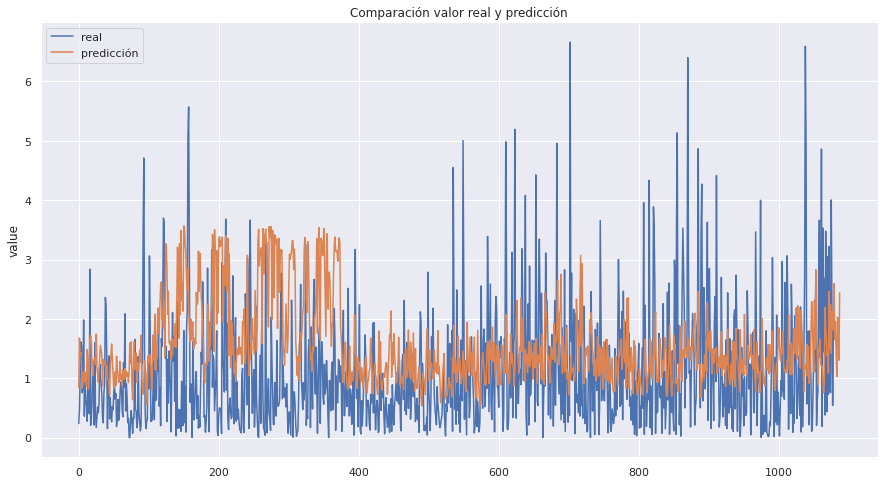

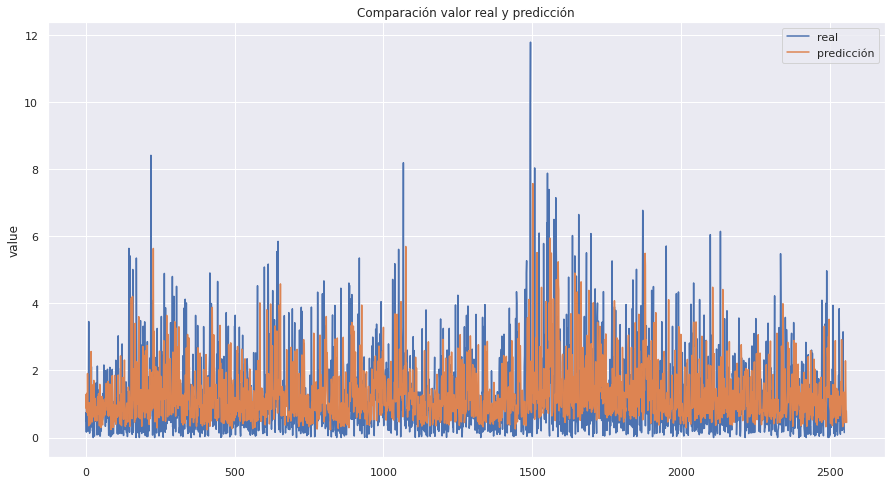

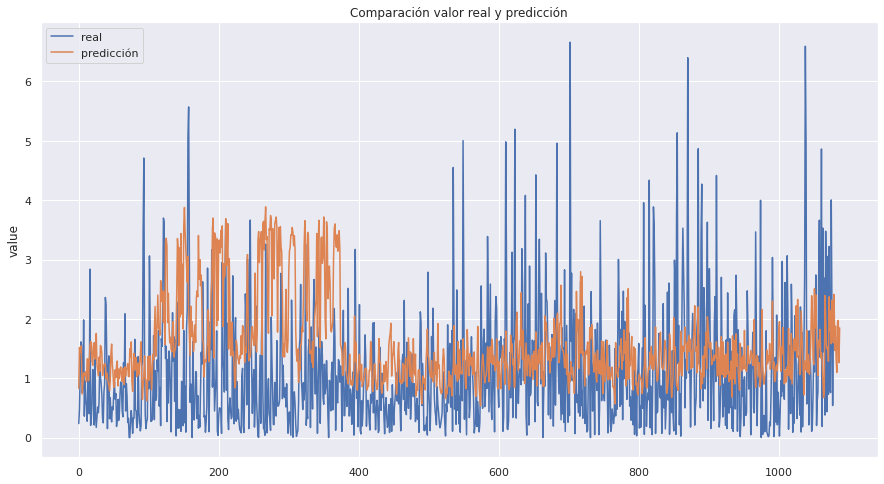

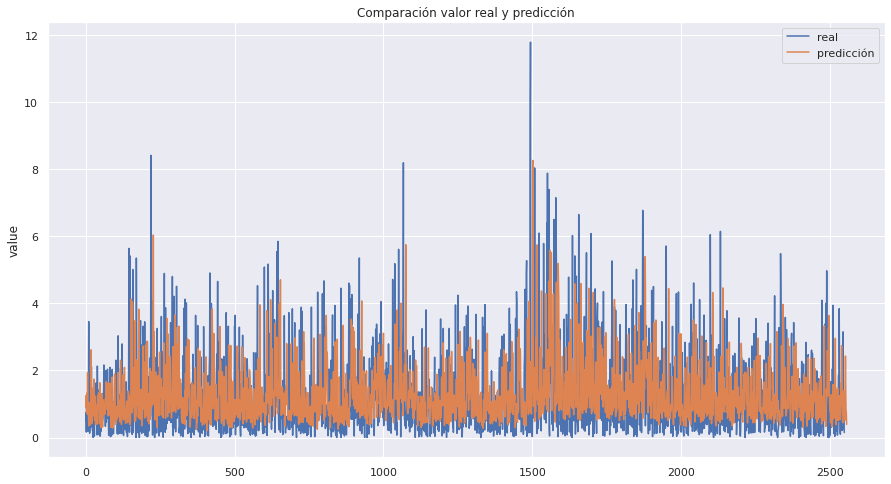

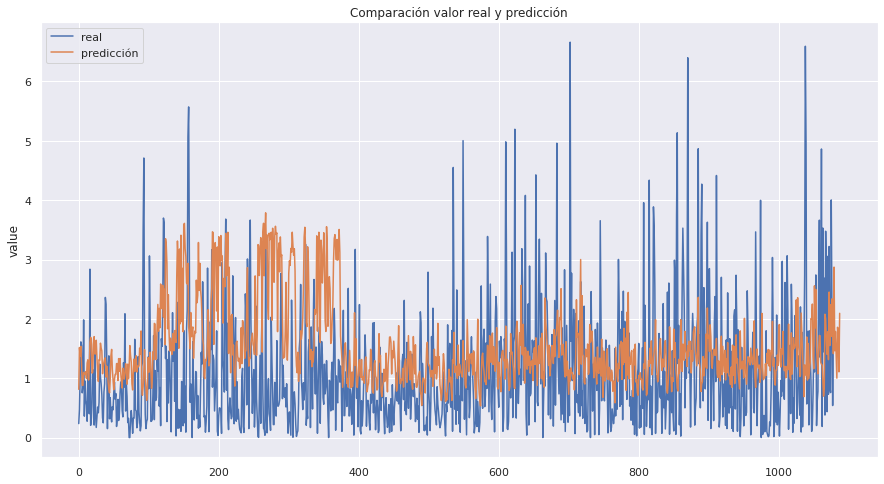

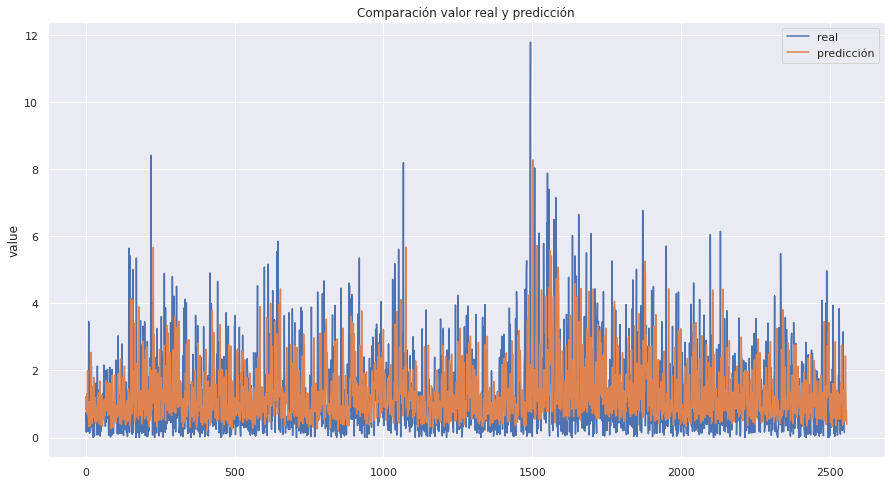

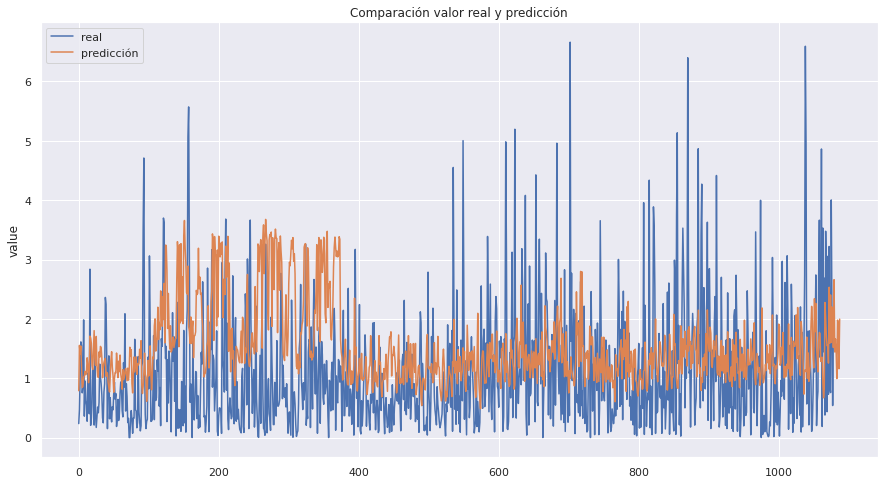

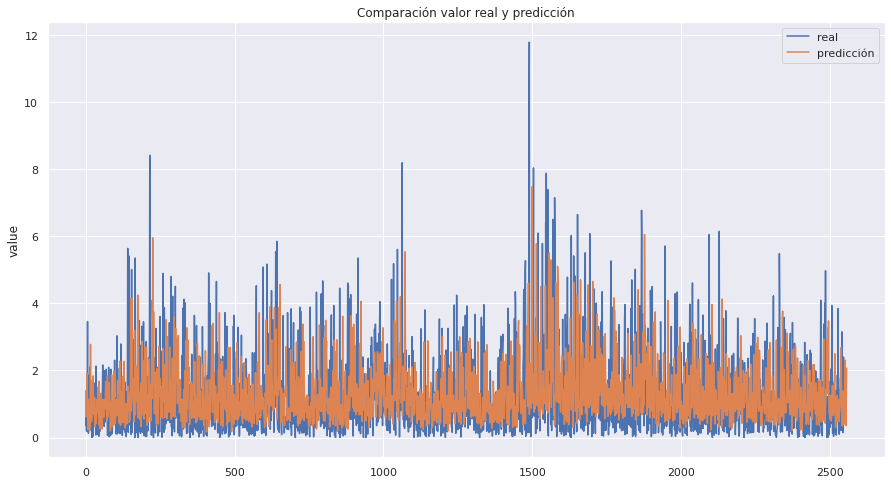

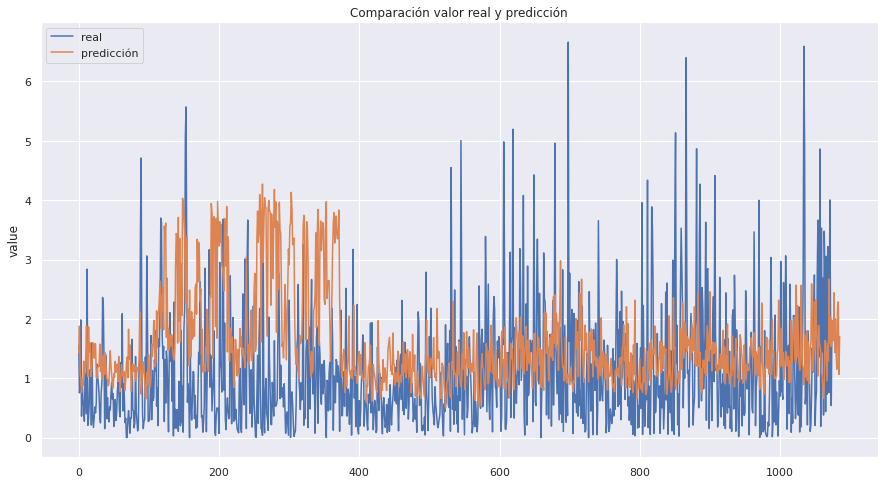

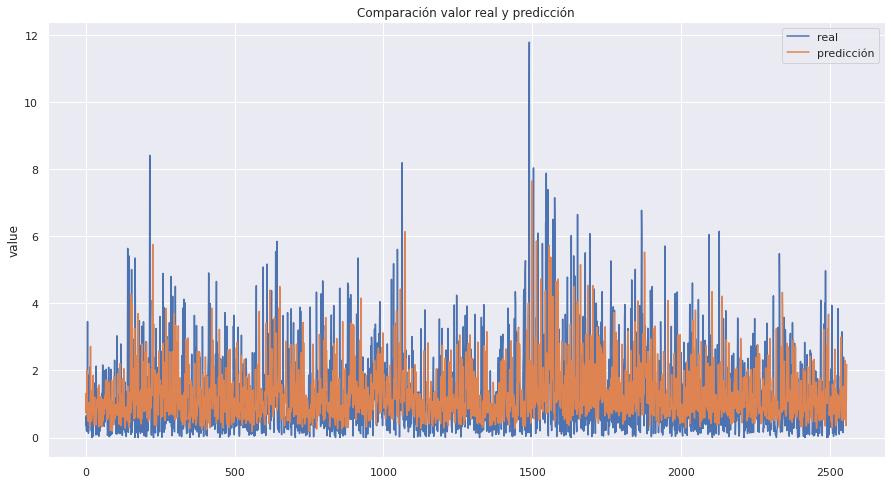

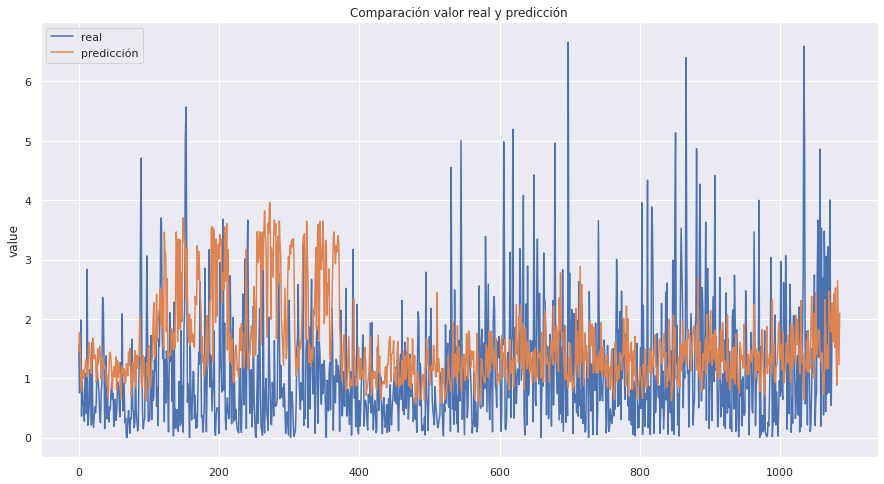

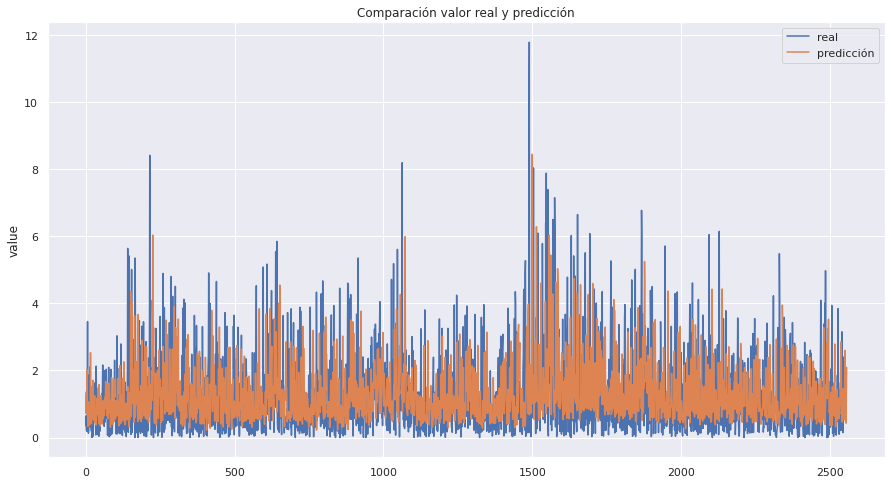

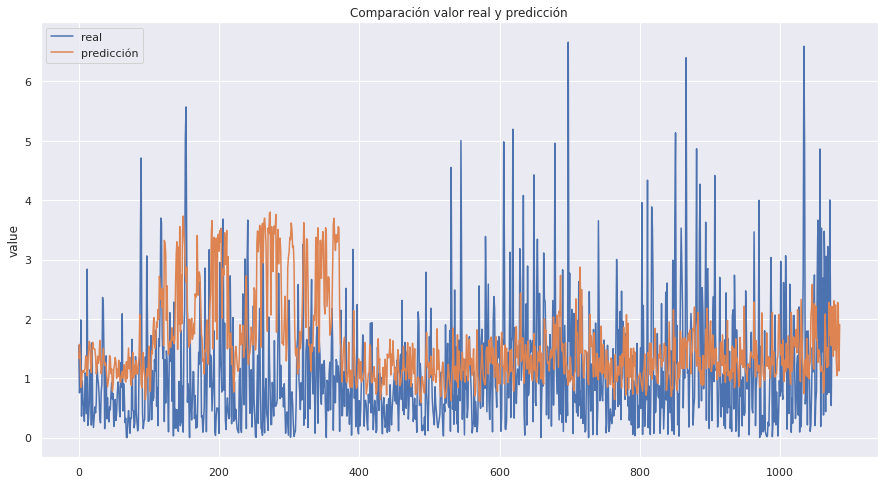

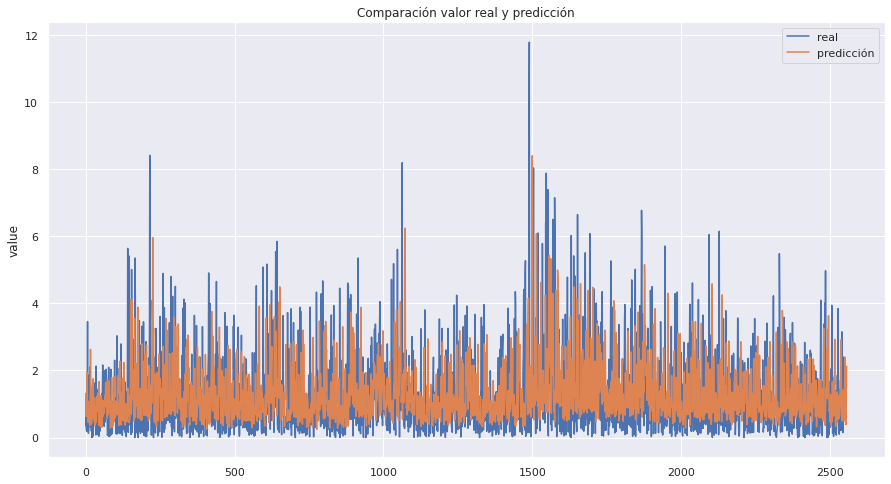

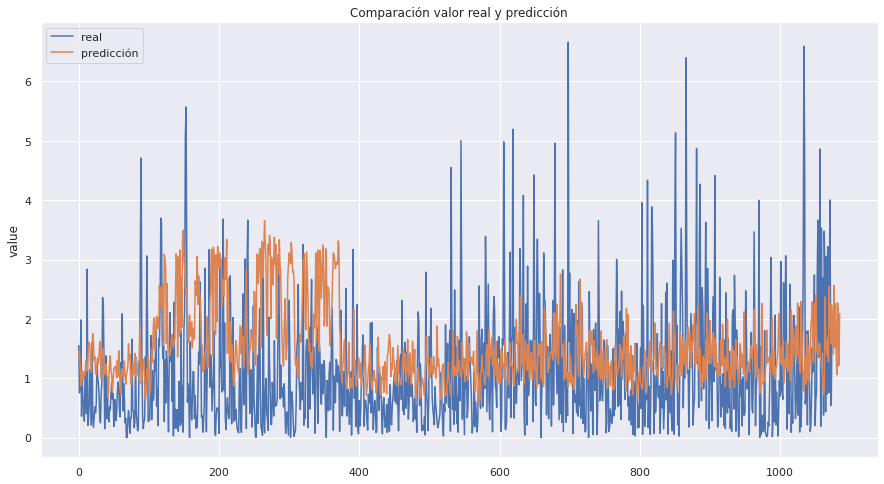

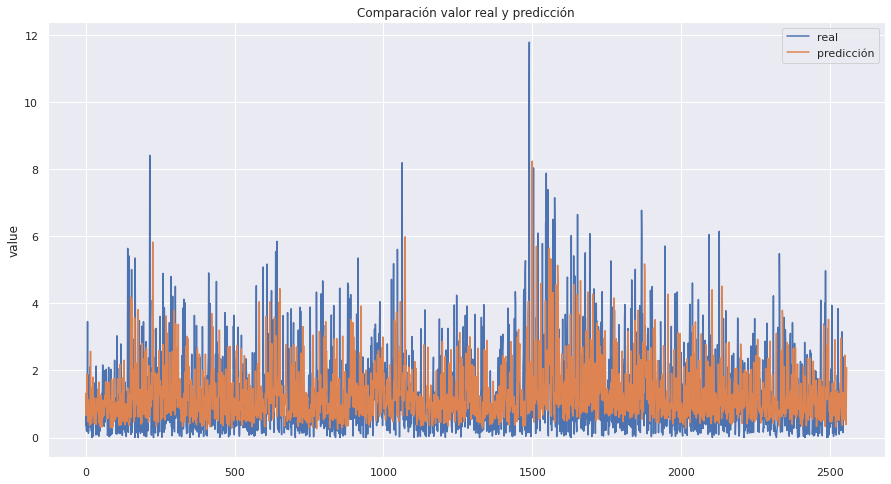

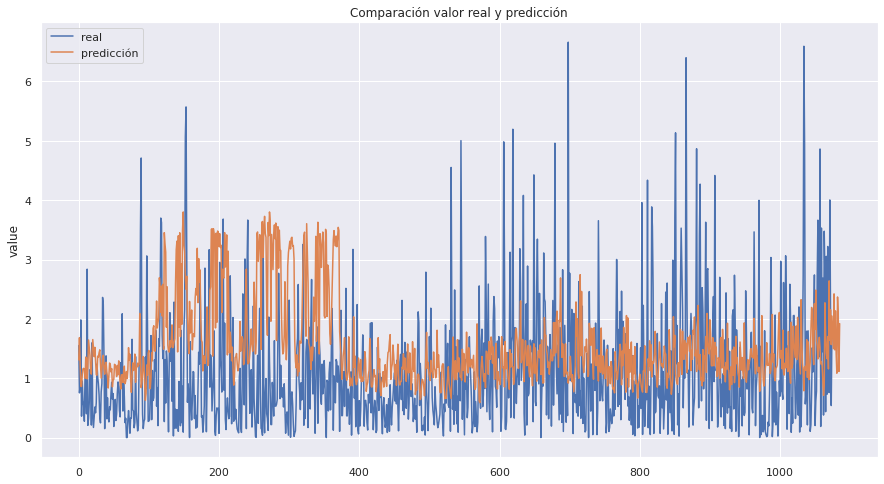

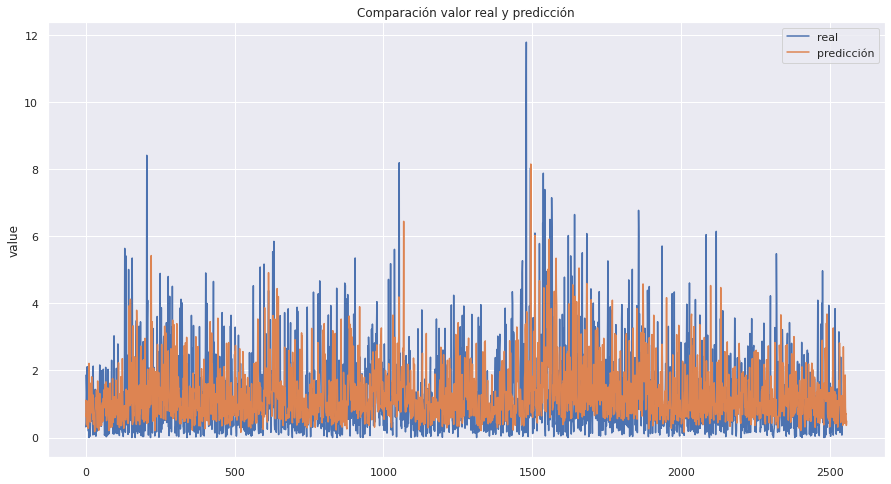

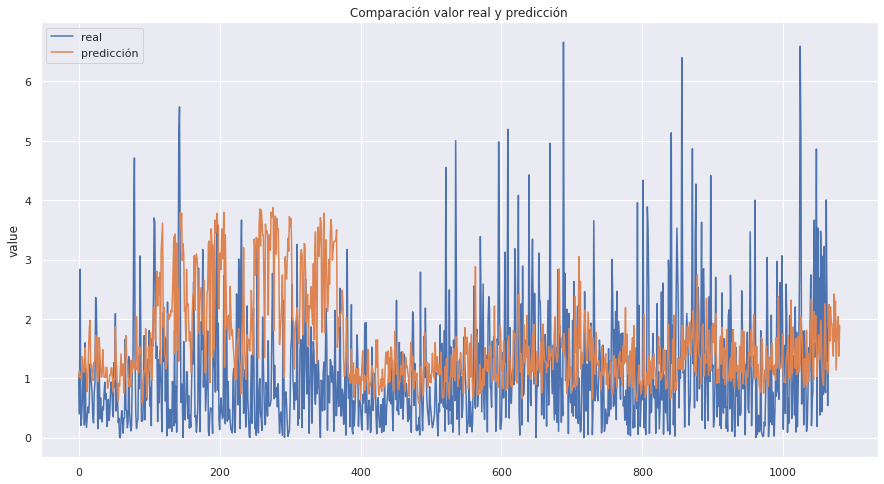

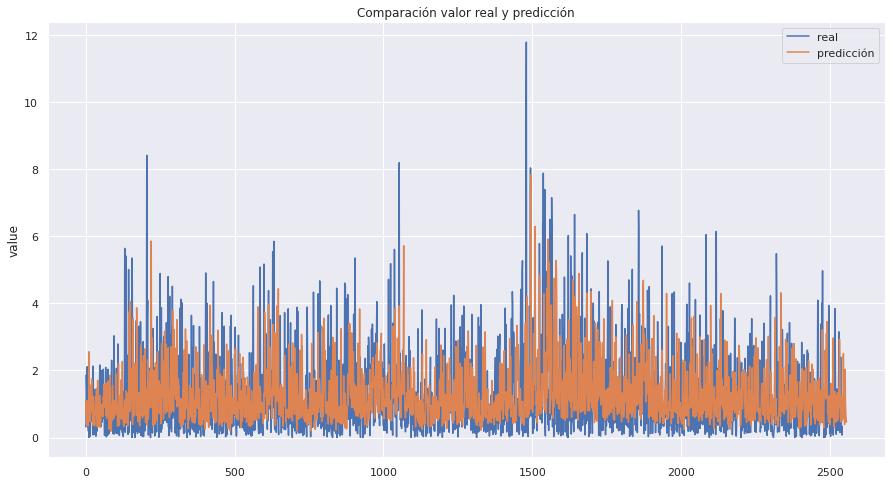

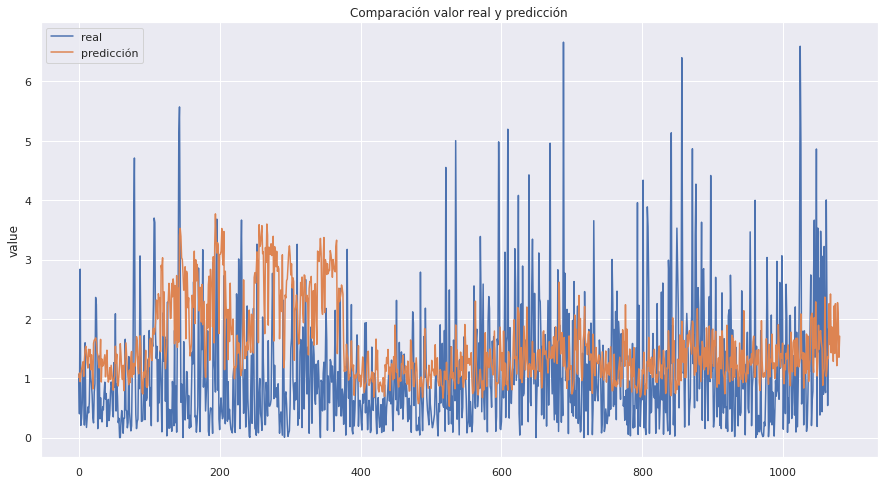

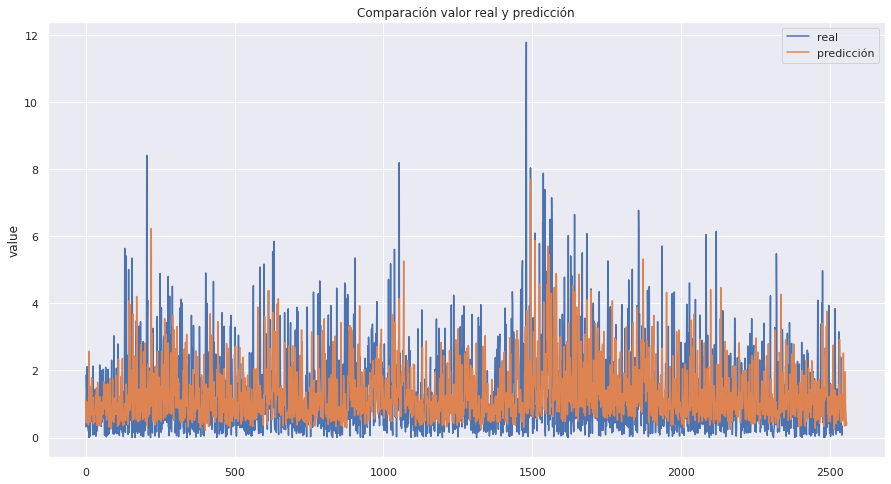

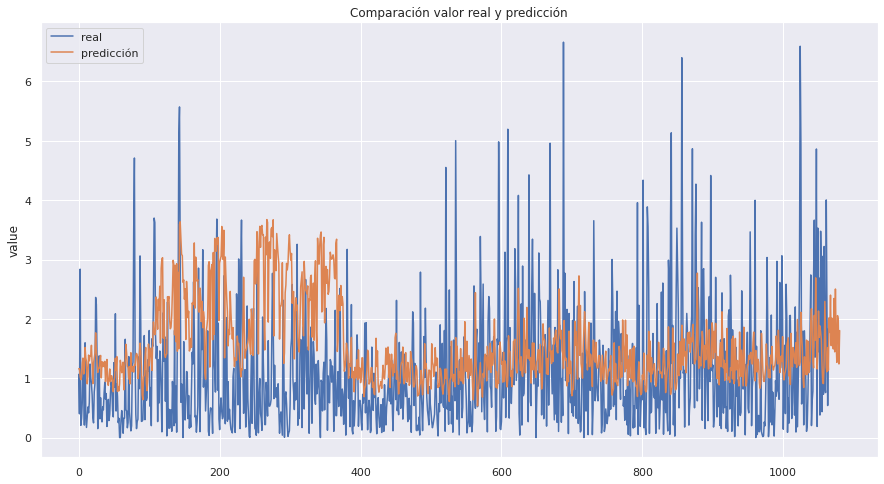

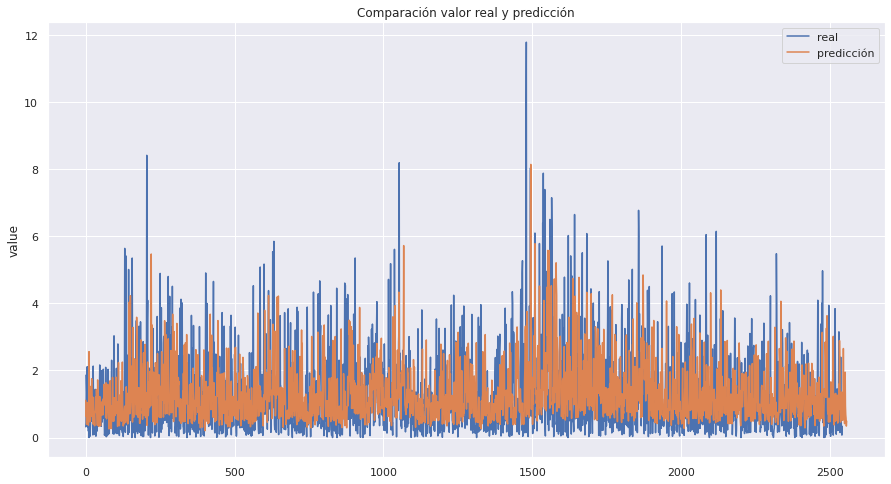

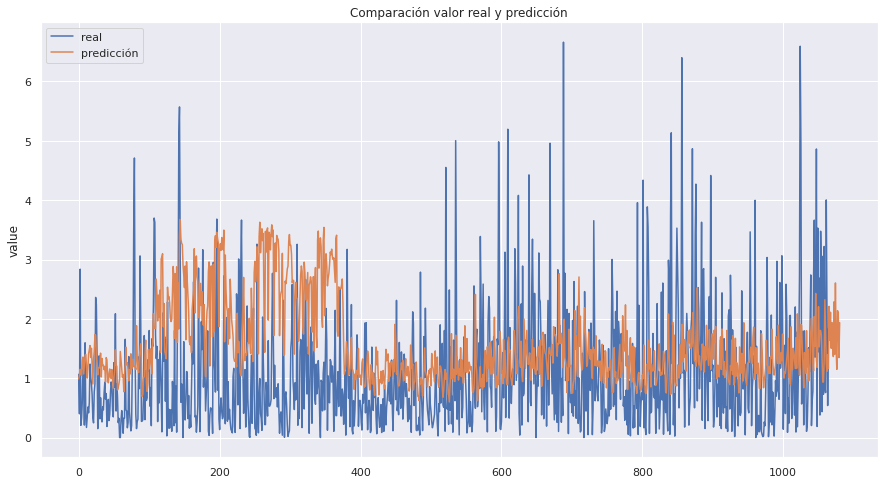

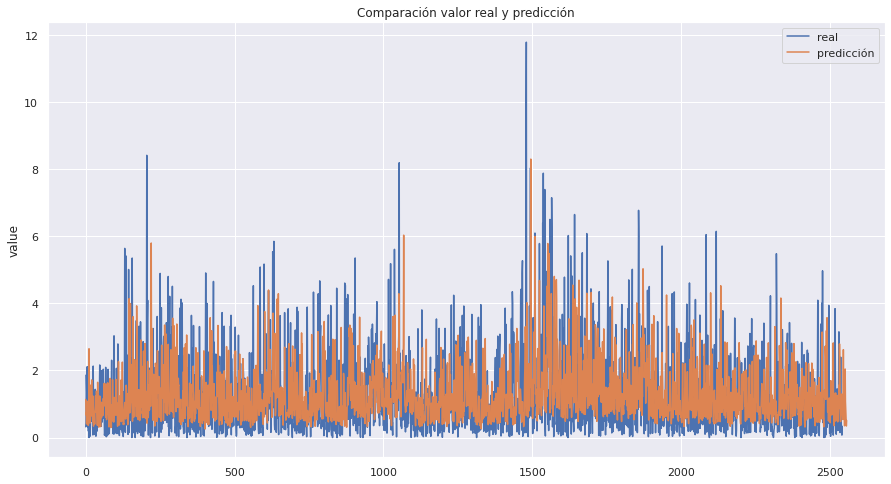

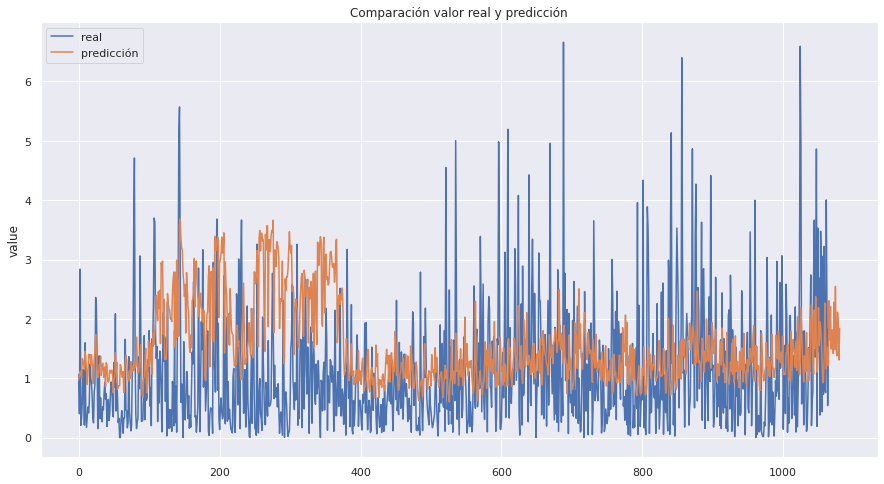

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)